## Introduction

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    competition = 'titanic'
    path = Path(f'/root/{competition}')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(competition, path=path)
        zipfile.ZipFile(f'{path}/titanic.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

In [3]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.fillna(modes, inplace=True)

In [7]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


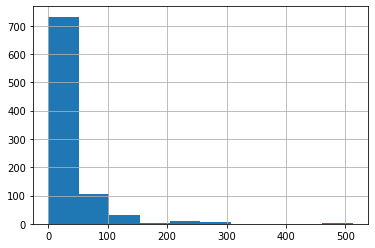

In [9]:
df['Fare'].hist();

In [10]:
df['LogFare'] = np.log(df['Fare']+1)

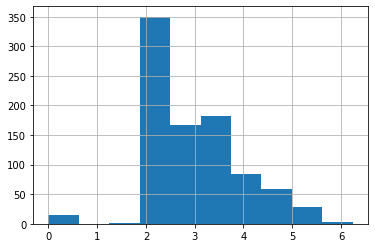

In [11]:
df['LogFare'].hist();

In [12]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [13]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
added_cols = list(pd.get_dummies(df[["Sex","Pclass","Embarked"]], columns=["Sex","Pclass","Embarked"]).columns)
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
df[added_cols].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


In [16]:
from torch import tensor

t_dep = tensor(df.Survived)

In [17]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [18]:
t_indep.shape

torch.Size([891, 12])

## Setting up a linear model

In [19]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [20]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.3147,   0.0000

In [21]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [22]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [23]:
preds = (t_indep*coeffs).sum(axis=1)

In [24]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770])

In [25]:
preds.mean()

tensor(-0.0094)

In [26]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5200)

In [27]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In [28]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [29]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [30]:
loss.backward()

In [31]:
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,  0.0797, -0.1886, -0.0617,  0.1639])

In [32]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0967,  0.0236, -0.0082, -0.1608, -0.3951,  0.2222, -0.2469, -0.0853,  0.1594, -0.3771, -0.1235,  0.3277])

In [33]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4809)


## Training the linear model

In [34]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [35]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [36]:
trn_split

(#713) [788,525,821,253,374,98,215,313,281,305...]

In [37]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [38]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [39]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [40]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [41]:
coeffs = train_model(18, lr=0.2)

0.518; 0.491; 0.468; 0.445; 0.422; 0.400; 0.378; 0.358; 0.340; 0.327; 0.315; 0.306; 0.308; 0.311; 0.311; 0.292; 0.296; 0.287; 

In [42]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2581),
 'SibSp': tensor(0.0894),
 'Parch': tensor(0.2346),
 'LogFare': tensor(0.0275),
 'Sex_female': tensor(0.2574),
 'Sex_male': tensor(-0.4129),
 'Pclass_1': tensor(0.7098),
 'Pclass_2': tensor(0.4246),
 'Pclass_3': tensor(0.3691),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2490),
 'Embarked_S': tensor(0.2116)}

## Measuring accuracy

In [43]:
preds = calc_preds(coeffs, val_indep)

In [46]:
preds

tensor([ 0.8650,  0.1373, -0.0164,  0.1843,  0.1544,  0.1385,  0.7599,  0.8149,  0.3157,  0.7087,  0.0742,  0.0368,  0.2162,  0.8077,
         0.0670,  0.3779,  0.3134,  0.8666,  0.1121,  0.7481,  0.1000,  0.3425,  1.0079,  0.8467,  0.1125,  0.1532,  0.8961,  0.3231,
         0.1230,  0.8076,  0.9254,  0.9376,  0.1161,  0.0791,  0.8457,  0.9699,  0.3725,  1.0040,  0.1001,  0.7782,  0.1728,  0.1001,
         0.1984,  0.9786,  0.1130,  0.9177,  0.1018,  0.1515,  0.1369,  0.7764,  0.4462,  0.2899,  0.2770,  0.0963,  0.1503,  0.1309,
         0.1373,  0.0752,  0.1098,  0.0884,  0.3104,  0.1333,  0.2656,  0.1097,  0.7774,  0.4991,  0.1576,  0.0562,  0.1388,  0.7603,
         0.0936,  0.7350,  0.1341,  0.1007,  0.4456,  0.1258,  0.1001,  0.4170,  0.1737,  0.0840,  0.2979,  1.1200,  0.1032,  0.0997,
         0.7431,  0.1325,  0.3662,  1.2441,  0.7126,  0.1608,  0.0744,  0.1001,  0.9865, -0.0358,  0.7943,  0.0027,  0.0895,  0.8345,
         0.8141,  0.1529,  0.1696,  0.8076,  0.0742,  0.0807, 

In [44]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [47]:
results.float().mean()

tensor(0.7978)

In [48]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7978)

## Using sigmoid

In [49]:
preds[:28]

tensor([ 0.8650,  0.1373, -0.0164,  0.1843,  0.1544,  0.1385,  0.7599,  0.8149,  0.3157,  0.7087,  0.0742,  0.0368,  0.2162,  0.8077,
         0.0670,  0.3779,  0.3134,  0.8666,  0.1121,  0.7481,  0.1000,  0.3425,  1.0079,  0.8467,  0.1125,  0.1532,  0.8961,  0.3231])

In [50]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

ModuleNotFoundError: No module named 'sympy'

In [52]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [56]:
coeffs = train_model(lr=100)

0.503; 0.326; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [54]:
acc(coeffs)

tensor(0.8258)

In [55]:
show_coeffs()

{'Age': tensor(-1.5097),
 'SibSp': tensor(-1.1564),
 'Parch': tensor(-0.4253),
 'LogFare': tensor(0.2456),
 'Sex_female': tensor(8.4482),
 'Sex_male': tensor(-10.3873),
 'Pclass_1': tensor(3.8377),
 'Pclass_2': tensor(2.1304),
 'Pclass_3': tensor(-6.2481),
 'Embarked_C': tensor(1.4744),
 'Embarked_Q': tensor(2.1067),
 'Embarked_S': tensor(-4.8086)}

## Submitting to Kaggle

In [ ]:
tst_df = pd.read_csv(path/'test.csv')

In [ ]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [ ]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [ ]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [ ]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [ ]:
!head sub.csv

## Using matrix product

In [ ]:
(val_indep*coeffs).sum(axis=1)

In [ ]:
val_indep@coeffs

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [ ]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [ ]:
coeffs = train_model(lr=100)

In [ ]:
acc(coeffs)

## A neural network

In [ ]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [ ]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [ ]:
coeffs = train_model(lr=1.4)

In [ ]:
coeffs = train_model(lr=20)

In [ ]:
acc(coeffs)

## Deep learning

In [ ]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [ ]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [ ]:
coeffs = train_model(lr=4)

In [ ]:
acc(coeffs)

## Final thoughts